# Dataset (from Kaggle)

In [ ]:
! pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d awsaf49/brats2020-training-data

100% 6.73G/6.76G [01:13<00:00, 238MB/s]
100% 6.76G/6.76G [01:13<00:00, 99.0MB/s]


In [ ]:
import zipfile
import os

zip_file_path = '/content/brats2020-training-data.zip'

extract_dir = 'data/'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files (images)
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['BraTS2020_training_data', 'BraTS20 Training Metadata.csv']


# MSR Augmentation Implementation

In [ ]:
import torchvision.transforms as transforms

Define augmentation parameters and transforms as required

In [ ]:
msr_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

In [ ]:
# augmented_image = msr_augmentation(img)

# SPN Augmentation Implementation

In [ ]:
import torch
import random

In [ ]:
class SPNAugmentation(object):
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    # img - image tensor with shape (C, H, W).
    def __call__(self, img):
        patch_size = 4
        batch_size, C, H, W = img.shape
        num_patches_h = H
        num_patches_w = W

        for b in range(batch_size):
            for h in range(num_patches_h):
                for w in range(num_patches_w):
                    if np.random.rand() < self.noise_level:
                        y1 = h * patch_size
                        y2 = min(y1 + patch_size, H)
                        x1 = w * patch_size
                        x2 = min(x1 + patch_size, W)
                        patch = img[b, :, y1:y2, x1:x2]
                        shuffled_patch = patch[:, np.random.permutation(patch.shape[1]), :][:, :, np.random.permutation(patch.shape[2])]
                        img[b, :, y1:y2, x1:x2] = shuffled_patch

        return img

In [ ]:
spn = SPNAugmentation(noise_level=0.2)
# augmented_image = spn(img)

# Converting Image to C, H, W tensor

In [ ]:
from PIL import Image
import numpy as np
import torch
import h5py


In [ ]:
def convert_h5_to_tensor(path):
    with h5py.File(path, 'r') as file:
        image_array = np.array(file['image'])
        image_tensor = torch.from_numpy(image_array)
        image_tensor = image_tensor.permute(2, 0, 1)
        image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

# Applying the transforms

torch.Size([1, 3, 240, 240])


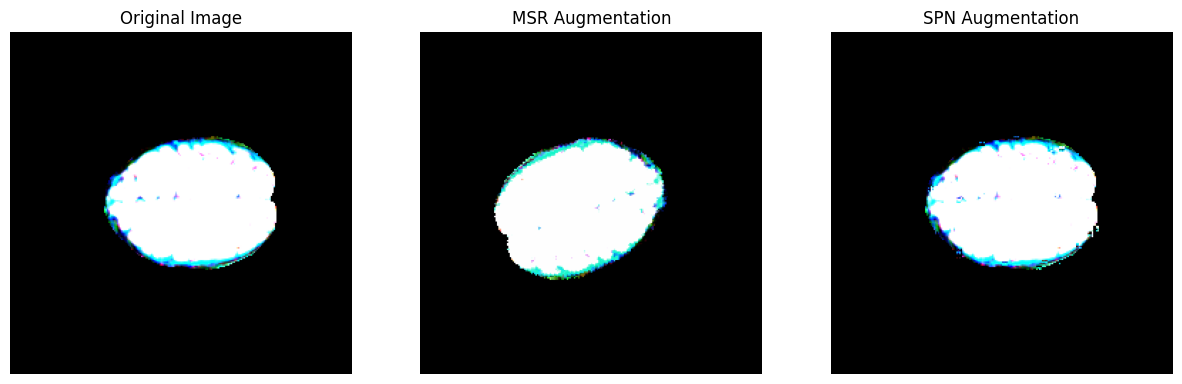

torch.Size([1, 3, 240, 240])


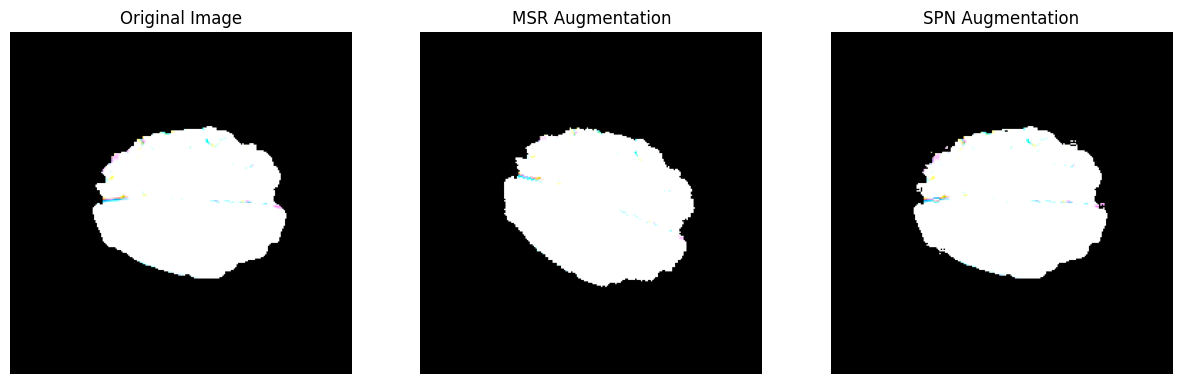

torch.Size([1, 3, 240, 240])


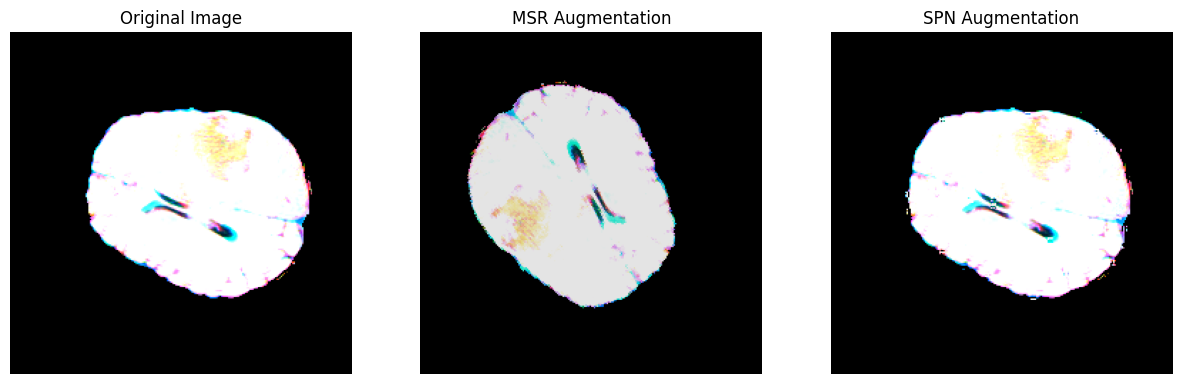

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import h5py

data_dir = '/content/data/BraTS2020_training_data/content/data/'

file_list = ['volume_156_slice_117.h5', 'volume_252_slice_115.h5', 'volume_365_slice_85.h5']

for file_name in file_list:
    file_path = data_dir + file_name
    original_image_tensor = convert_h5_to_tensor(file_path)

    # Convert 4-channel image to 3 channels
    selected_channels = [0, 1, 2]
    original_image_tensor = original_image_tensor[:, selected_channels, :, :]

    # Apply MSR augmentation
    transformed_image_msr = msr_augmentation(original_image_tensor.clone())

    # Apply SPN augmentation
    spn_augmentation = SPNAugmentation(noise_level=0.1)
    print(original_image_tensor.clone().shape)
    transformed_image_spn = spn_augmentation(original_image_tensor.clone())

    # Convert tensors to numpy arrays for display
    original_image = original_image_tensor.squeeze().permute(1, 2, 0).numpy()
    msr_image = transformed_image_msr.squeeze().permute(1, 2, 0).numpy()
    spn_image = transformed_image_spn.squeeze().permute(1, 2, 0).numpy()

    # Display original and augmented images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(msr_image)
    plt.title('MSR Augmentation')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(spn_image)
    plt.title('SPN Augmentation')
    plt.axis('off')

    plt.show()